In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim  as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

if torch.cuda.is_available():
   print("Your Colab notebook is configured to run on the GPU!")
else:
   print("If you see this message, your Colab notebook is currently running on the CPU. Click the Runtime dropdown menu, select Change runtime type, and  choose GPU in the list of Hardware accelerators")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Your Colab notebook is configured to run on the GPU!


In [89]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Part 1

In [2]:
torch.__version__

'1.6.0+cu101'

In [3]:
torchvision.__version__

'0.7.0+cu101'

In [4]:
np.__version__

'1.18.5'

In [5]:
import sklearn
sklearn.__version__

'0.22.2.post1'

In [6]:
import matplotlib
matplotlib.__version__

'3.2.2'

## Part 2

Time for the “Hello World” of deep learning: train a handwritten digit classifier using PyTorch. The choice of the network architecture is up to you, the goal is to simply get at least 95% accuracy on the test set! Note that the MNIST dataset is already available as part of the torchvision package.

In [2]:
from torchvision import datasets

In [3]:
dataset_mnist_train = torchvision.datasets.MNIST('/files/', train = True, download = True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))
                             ]))

dataset_mnist_test =  torchvision.datasets.MNIST('/files/', train = False, download = True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))
                             ]))

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
from sklearn.model_selection import train_test_split

In [10]:
batch_size_train = 32
n_epochs = 3
batch_size_test = 1000

In [73]:
# number of subprocesses to use for data loading
num_workers = 0

# percentage of training set to use as validation
valid_size = 0.2

targets = dataset_mnist_train.targets
train_idx, valid_idx= train_test_split(np.arange(len(targets)), test_size = valid_size,  stratify = targets)

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [95]:
train_loader = torch.utils.data.DataLoader(dataset_mnist_train , batch_size = batch_size_train, sampler = train_sampler,  num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_mnist_train, batch_size =  batch_size_train, sampler = valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset_mnist_test, batch_size = batch_size_train,  num_workers = num_workers)

In [77]:
len(valid_idx)

12000

In [76]:
print("train",np.unique((targets[train_idx]), return_counts = True))
print("valid",np.unique((targets[valid_idx]), return_counts = True))

train (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([4738, 5394, 4766, 4905, 4674, 4337, 4734, 5012, 4681, 4759]))
valid (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1185, 1348, 1192, 1226, 1168, 1084, 1184, 1253, 1170, 1190]))


In [13]:
batch_img = enumerate(valid_loader)
batch_idx, (example_data, example_targets) = next(batch_img)

In [14]:
example_data.shape

torch.Size([32, 1, 28, 28])

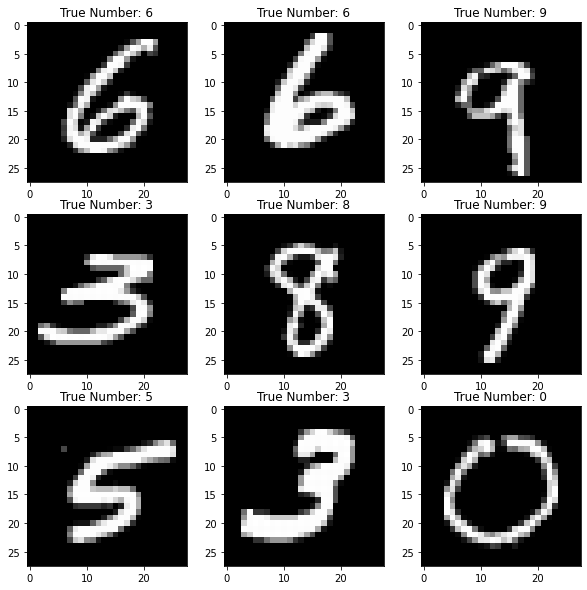

In [78]:
fig, axes = plt.subplots(3, 3, figsize = (10, 10))
axes = axes.ravel()

for i in range(0, 9):
  axes[i].imshow(example_data[i][0], cmap='gray', interpolation='none')
  axes[i].set_title("True Number: {}".format(example_targets[i]))

#### model training

In [96]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3)
        self.conv2 = nn.Conv2d(16, 20, kernel_size = 5)
        self.conv2_drop = nn.Dropout2d()
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)

        self.fc1 = nn.Linear(320, 50)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [123]:
learning_rate = 0.001
momentum = 0.5
log_interval = 10
n_epochs = 30
model = MNISTNet()
optimizer = optim.SGD(network.parameters(), lr = learning_rate,
                      momentum=momentum)

In [124]:
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [125]:
# create a complete CNN

print(model)

# move tensors to GPU if CUDA is available
model.cuda()

MNISTNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


MNISTNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [126]:
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss
train_history = []
valid_history = []
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    correct_train = 0
    correct_valid = 0
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

        pred_train = output.data.max(1, keepdim=True)[1]
        correct_train += pred_train.eq(target.data.view_as(pred_train)).sum()  


    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)

        pred_valid = output.data.max(1, keepdim=True)[1]
        correct_valid += pred_valid.eq(target.data.view_as(pred_valid)).sum() 

    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(test_loader.sampler)

    train_history.append(train_loss)    
    valid_history.append(valid_loss)

    accuracy_train = 100. * correct_train / len(train_loader.dataset)
    accuracy_valid = 100. * correct_valid/ len(test_loader.dataset)
    print('Epoch: {} \tTraining Loss - Accuracy: {:.6f}, {:.6f} \tValidation Loss -  Accuracy: {:.6f}, {:.6f}'.format(
        epoch, train_loss, accuracy_train,  valid_loss, accuracy_valid))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 	Training Loss - Accuracy: 2.271276, 13.335000 	Validation Loss -  Accuracy: 2.177991, 47.799999
Epoch: 2 	Training Loss - Accuracy: 1.990925, 26.306667 	Validation Loss -  Accuracy: 1.392909, 73.830002
Epoch: 3 	Training Loss - Accuracy: 1.342797, 44.686668 	Validation Loss -  Accuracy: 0.709500, 83.419998
Epoch: 4 	Training Loss - Accuracy: 0.987265, 54.650002 	Validation Loss -  Accuracy: 0.511789, 87.290001
Epoch: 5 	Training Loss - Accuracy: 0.822514, 59.393333 	Validation Loss -  Accuracy: 0.405702, 89.320000
Epoch: 6 	Training Loss - Accuracy: 0.725300, 62.146667 	Validation Loss -  Accuracy: 0.352947, 90.339996
Epoch: 7 	Training Loss - Accuracy: 0.660065, 63.803333 	Validation Loss -  Accuracy: 0.312977, 91.349998
Epoch: 8 	Training Loss - Accuracy: 0.603230, 65.421669 	Validation Loss -  Accuracy: 0.281321, 92.079994
Epoch: 9 	Training Loss - Accuracy: 0.563296, 66.288338 	Validation Loss -  Accuracy: 0.259182, 92.639999
Epoch: 10 	Training Loss - Accuracy: 0.537116,

In [127]:
# specify the image classes
classes = [1,2,3,4,5,6,7,8,9,10]

In [128]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in test_loader:

    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)

    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    

    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test Loss: 0.117346

Test Accuracy of     1: 98% (969/980)
Test Accuracy of     2: 99% (1126/1135)
Test Accuracy of     3: 95% (988/1032)
Test Accuracy of     4: 95% (969/1010)
Test Accuracy of     5: 97% (957/982)
Test Accuracy of     6: 95% (855/892)
Test Accuracy of     7: 97% (935/958)
Test Accuracy of     8: 94% (976/1028)
Test Accuracy of     9: 94% (925/974)
Test Accuracy of    10: 94% (950/1009)

Test Accuracy (Overall): 96% (9650/10000)


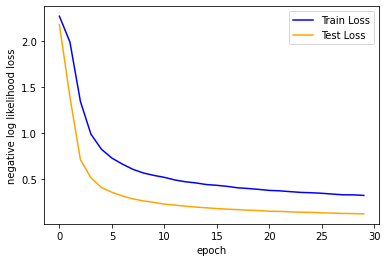

In [132]:
fig = plt.figure()
plt.plot(range(n_epochs), train_history, color='blue')
plt.plot(range(n_epochs), valid_history, color='orange')
# plt.scatter(test_counter, test_losses[0:4], color='red')
plt.legend(['Train Loss', 'Test Loss'], loc = 'upper right')
plt.xlabel('epoch')
plt.ylabel('negative log likelihood loss')
plt.show()